In [9]:
!pip install pyautogui
!pip install annoy
!pip install tensorflow_hub

In [1]:
import annoy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pyautogui
import pyperclip
import pytesseract
import string
import random
import tensorflow as tf
import tensorflow_hub as hub
import time
os.environ['TFHUB_CACHE_DIR'] = os.getcwd()

In [2]:
def screenshot(bbox=None): #bbox format : left - top - width - height
    return pyautogui.screenshot(region=bbox)

FIGSIZE = (6,6)
def plot_img(image, figsize=FIGSIZE,cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(image,cmap=cmap)

In [3]:
def start_game():
    pyautogui.click(242, 585)
    pyautogui.click(242, 585)

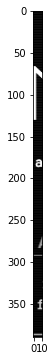

In [4]:
triangle_area = (218,130,11,390) #218
threshold = 120
fn = lambda x : 255 if x> threshold else 0
resize = 1
screen = screenshot(triangle_area).convert("L")
plot_img(screen,cmap = 'gray')
array_screen = np.array(screen)

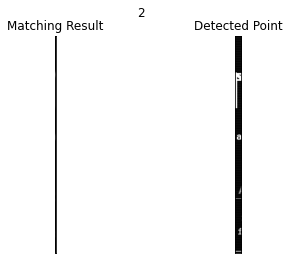

In [5]:
template = cv2.imread(os.path.join('images','arrow.png'), cv2.IMREAD_GRAYSCALE)

w, h = template.shape

method = cv2.TM_CCORR
img = array_screen.copy()
res = cv2.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle(method)
plt.show()

In [6]:
threshold = 120
fn = lambda x : 255 if x> threshold else 0
resize = 1
triangle_area = (220,130,11,390)

def take_screenshot():
    return np.array(screenshot(triangle_area).convert("L"))

def screenshot_text(line_index):
    text_area = (239,130 + line_index - 6, 240,21)
    text_screen = screenshot(text_area).convert("L")
    return np.array(text_screen)

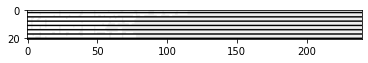

In [7]:
tim = time.time()
method = cv2.TM_CCORR

def find_arrow_index() : 
    screen = take_screenshot()
    res = cv2.matchTemplate(screen,template,method)
    _, _, _, max_loc = cv2.minMaxLoc(res)
    return max_loc[1]

arrow_index = find_arrow_index()
text_screen = screenshot_text(arrow_index) #line_index
plot_img(text_screen,cmap='gray')

In [8]:
embedding_dimension = 64
index_filename = 'indexes/index2'
index = annoy.AnnoyIndex(embedding_dimension,metric = 'angular')
index.load(index_filename)
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
    mapping = pickle.load(handle)
print('Mapping file is loaded.')

Annoy index is loaded.
Mapping file is loaded.


In [9]:
model_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
print("Loading the TF-Hub model...")
try : 
    %time embed_fn = hub.load(model_url)
except OSError as oserror : 
    print("Check the access rights of current folder")
print("TF-Hub model is loaded.")

Loading the TF-Hub model...


2022-10-09 16:47:06.222337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 6.48 s, sys: 2.55 s, total: 9.03 s
Wall time: 12.7 s
TF-Hub model is loaded.


In [10]:
def find_similar_items(embedding, num_matches=5):
    '''Finds similar items to a given embedding in the ANN index'''
    ids = index.get_nns_by_vector(embedding, num_matches, search_k=-1, include_distances=False)
    items = [mapping[i] for i in ids]
    return items

In [11]:
random_projection_matrix = None
random_projection_matrix_filename = os.path.join('random_projection_matrices','random_projection_matrix2')
if os.path.exists(random_projection_matrix_filename):
    print("Loading random projection matrix...")
    with open(random_projection_matrix_filename, 'rb') as handle:
        random_projection_matrix = pickle.load(handle)
    print('random projection matrix is loaded.')

def extract_embeddings(query):
    '''Generates the embedding for the query'''
    query_embedding =  embed_fn([query])[0].numpy()

    if random_projection_matrix is not None:
        query_embedding = random_projection_matrix.transform(query_embedding.reshape(1,-1)).reshape(-1,)
    return query_embedding

Loading random projection matrix...
random projection matrix is loaded.


/Users/paul/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianRandomProjection from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
query = 'treadmill'

print("Generating embedding for the query...")
%time query_embedding = extract_embeddings(query)

print("")
print("Finding relevant items in the index...")
%time items = find_similar_items(query_embedding, 10)

print("")
for item in items:
    print(item)
    

Generating embedding for the query...
CPU times: user 667 ms, sys: 95.2 ms, total: 763 ms
Wall time: 1.39 s

Finding relevant items in the index...
CPU times: user 28 ms, sys: 53.8 ms, total: 81.8 ms
Wall time: 201 ms

treadmill
jogging
feline
resize
clubbing
gym
divorce
gymnasium
concourse
gecko


In [13]:
import time
tim = time.time()
text = pytesseract.image_to_string(text_screen,config='--psm 10 --oem 3')
print(text, time.time() - tim)

——————
 0.8806729316711426


In [14]:
def begin_with(root,words) :
    return not root.startswith(words[:3])

def get_words(query,items): 
    return list(filter(lambda word : begin_with(query,word),items))

punctuation = string.punctuation
not_accepted_punctutation = punctuation[:6] + punctuation[7:]
def is_possible_text(text):
    if len(text) <= 2 : 
        return False
    for character in not_accepted_punctutation : 
        if character in text : 
            return False
    return True

In [17]:
def run(verbose = False):
    line_index = -1
    while True :   
        line_index_temp = find_arrow_index()
        
        if line_index_temp < 20 : 
            continue
        if abs(line_index - line_index_temp) < 5 : 
            break
        line_index = line_index_temp
    text_screen = screenshot_text(line_index)
    if verbose : 
        plot_img(text_screen,cmap='gray')
    try : 
        text = pytesseract.image_to_string(text_screen,config='--psm 10 --oem 3')
        text = text.strip().lower()
    except IndexError : 
        return
    if not is_possible_text(text) : 
        return
    print(text)
    query_embedding = extract_embeddings(text)
    items = find_similar_items(query_embedding, 10)
    words = get_words(text,items)
    print(words)
    selected_word = words[random.randint(0,(len(words)-1))//2]
    pyperclip.copy(selected_word)
    pyautogui.click(x=100, y=200)
    pyautogui.hotkey('command', 'v')
    pyautogui.press('enter')

cake
['gateau', 'gateaux', 'trifle', 'fruitcake', 'baking', 'frosting', 'pie', 'steely', 'meteors']


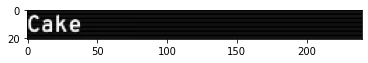

In [18]:
run(verbose=True)

In [16]:
while True:
    run()

teacher
sss sss
scissors
sports
sleep
cat
telephone
eye
dog
kitten
furniture
song
splsse
star
sword
hear
tea
candy
candy
mango
worm
onion
internet
ocean
marriage
ocean
water
microwave
muscle
tomato
peace
table
protein
ice cream
nurse
software
broadcasting
ice cream
broadcasting
pharmacy
twitter
srandfather clock


KeyboardInterrupt: 


Best score so far : 
- 3065
- 2870
- 2615
- 2610
- 2540
- 2405
- 2325

Complicated Words : 
- School
- Technology
- Camera
- Electricity
- Map
- Avocado
- Printing
- Rock climbing

In [ ]:
def remove_temporary_screenshots():
    !rm -fv screenshot*
    !rm -fv ..screenshot*

In [ ]:
remove_temporary_screenshots()
os.listdir()